In [1]:
!pip install image-classifiers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-08 09:40:01.810854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 09:40:01.810998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 09:40:01.998081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [6]:
from classification_models.tfkeras import Classifiers

In [7]:
ResNext101, preprocess_input = Classifiers.get("resnext101")

In [8]:
base_model = ResNext101(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

173622728/173622728 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    42,266,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,266,569 (161.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,266,569 (161.23 MB)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - AUC: 0.7247 - Precision: 0.6815 - Recall: 0.7120 - accuracy: 0.6691 - loss: 0.7611
Epoch 1: val_accuracy improved from -inf to 0.67014, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - AUC: 0.7257 - Precision: 0.6809 - Recall: 0.7125 - accuracy: 0.6694 - loss: 0.7602 - val_AUC: 0.8367 - val_Precision: 0.6119 - val_Recall: 0.9306 - val_accuracy: 0.6701 - val_loss: 0.8914
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - AUC: 0.8213 - Precision: 0.8013 - Recall: 0.7294 - accuracy: 0.7632 - loss: 0.5997
Epoch 2: val_accuracy improved from 0.67014 to 0.78472, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - AUC: 0.8218 - Precision: 0.8018 - Recall: 0.7295 - accuracy: 0.7635 - loss: 0.5987 - val_AUC: 0.9116 - val_Precision: 0.7228 - val_Recall: 0.9236 - val_accuracy: 0.7847 - val_loss: 0.5055
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - AUC: 0.8793 - Precision: 0.7438 - Recall: 0.8070

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.85069
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - AUC: 0.8846 - Precision: 0.7542 - Recall: 0.7635 - accuracy: 0.7551 - loss: 0.4072 - val_AUC: 0.8770 - val_Precision: 0.8099 - val_Recall: 0.7986 - val_accuracy: 0.8056 - val_loss: 0.4487
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - AUC: 0.9537 - Precision: 0.8696 - Recall: 0.9143 - accuracy: 0.9008 - loss: 0.2868
Epoch 7: val_accuracy did not improve from 0.85069
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - AUC: 0.9534 - Precision: 0.8699 - Recall: 0.9138 - accuracy: 0.9006 - loss: 0.2874 - val_AUC: 0.8796 - val_Precision: 0.7669 - val_Recall: 0.8681 - val_accuracy: 0.8021 - val_loss: 0.5173
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - AUC: 0.9070 - Precision: 0.8053 - Recall: 0.8209 - accuracy: 0.8112 - loss: 0.4046
Epoch 8: val_accuracy did not improve from 0.85069
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - AUC: 0.9066 - Precision: 0.8058 - Recall: 0.8200 - accuracy: 0.8108 - 

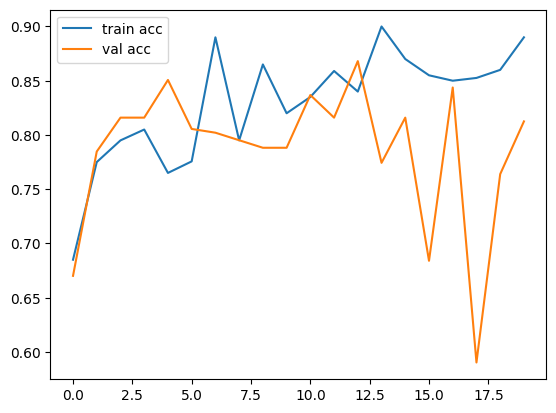

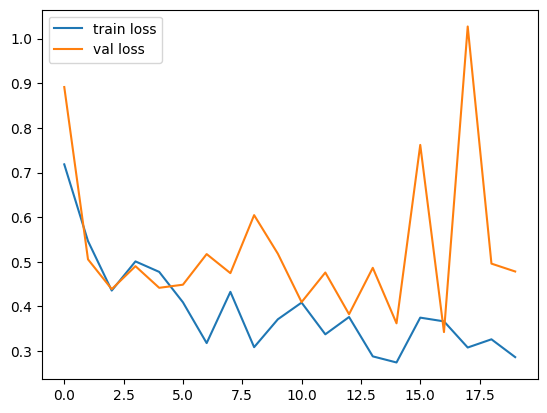

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('ResNext101_-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('ResNext101_-loss.png')
plt.show()

In [12]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 92s 867ms/step - AUC: 0.9117 - Precision: 0.9391 - Recall: 0.8688 - accuracy: 0.8781 - loss: 0.3743


[0.3318272829055786,
 0.8862559199333191,
 0.9363795518875122,
 0.925000011920929,
 0.8809523582458496]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
[[0.9932213]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


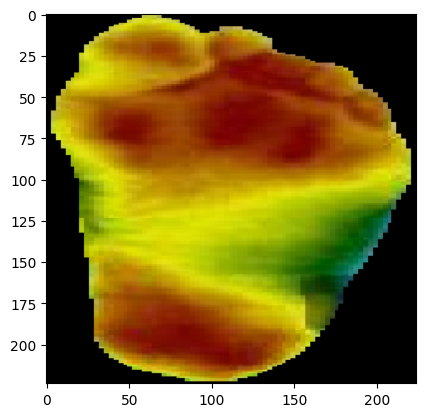

In [13]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))